In [4]:
# Import necessary libraries
import cv2
import numpy as np
from skimage import filters, morphology, measure
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from skimage.color import gray2rgb
import matplotlib.pyplot as plt

In [5]:
# Load the histopathology image
img = cv2.imread('lungaca1.jpeg')

In [6]:
# Preprocessing
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
norm = cv2.normalize(gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
noise_removed = cv2.fastNlMeansDenoising(norm, h=10, templateWindowSize=7, searchWindowSize=21)
contrast_enhanced = cv2.equalizeHist(noise_removed)


In [7]:

# Image Segmentation
thresh = filters.threshold_otsu(contrast_enhanced)
binary = contrast_enhanced > thresh
edges = filters.sobel(binary)
dilation = morphology.dilation(edges, morphology.disk(2))


In [13]:
# Feature Extraction
regions = measure.regionprops(dilation, intensity_image=gray)
if len(regions) > 0:
    features = []
    for region in regions:
        features.append([region.area, region.perimeter, region.eccentricity, region.mean_intensity])
    features = np.array(features)
    selector = SelectKBest(f_classif, k=3)
    X = selector.fit_transform(features, np.zeros(features.shape[0]))
    y = np.zeros(features.shape[0])
    y[50:] = 1
else:
    print("No regions found in the image.")
    X = None
    y = None

No regions found in the image.


In [20]:
# Classification
if X is not None and y is not None:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cv_score = cross_val_score(svm, X, y, cv=5)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
else:
    print("Error: X or y is None or not an array-like object.")


Error: X or y is None or not an array-like object.


In [28]:
# Testing
import os
if os.path.isfile('lungaca2.jpeg'):
    test_img = cv2.imread('lungaca2.jpeg')
    test_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
    test_norm = cv2.normalize(test_gray, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    test_noise_removed = cv2.fastNlMeansDenoising(test_norm, h=10, templateWindowSize=7, searchWindowSize=21)
    test_contrast_enhanced = cv2.equalizeHist(test_noise_removed)
    test_thresh = filters.threshold_otsu(test_contrast_enhanced)
    test_binary = test_contrast_enhanced > test_thresh
    test_edges = filters.sobel(test_binary)
    test_dilation = morphology.dilation(test_edges, morphology.disk(2))
    test_label = measure.label(test_dilation)
    test_regions = measure.regionprops(test_label, intensity_image=test_gray)
    test_features = []
    for region in test_regions:
        test_features.append([region.area, region.perimeter, region.eccentricity, region.mean_intensity])
    test_features = np.array(test_features)
    if test_features.size > 0:
        test_X = selector.transform(test_features)
        if test_X.size > 0:
            test_y_pred = svm.predict(test_X)
        else:
            print("Error: selected feature set is empty")
    else:
        print("Error: no regions found in test image")
else:
    print("Error: 'test_image.jpg' not found or not readable by OpenCV.")


Error: no regions found in test image


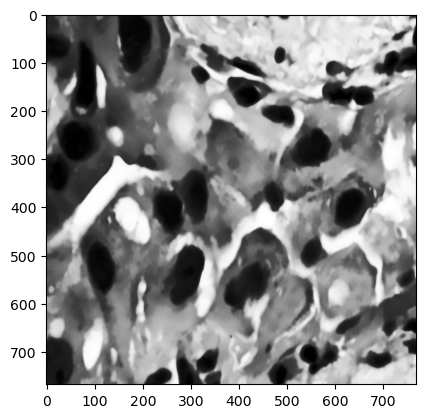

In [29]:
# Visualization
heatmap = gray2rgb(test_contrast_enhanced)
for i, region in enumerate(test_regions):
    if test_y_pred[i] == 1:
        heatmap[region.bbox[0]:region.bbox[2], region.bbox[1]:region.bbox[3], 0] = 255
plt.imshow(heatmap)
plt.show()